In [119]:
import pandas as pd
import numpy as np
import scipy as sp

import random

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import multiprocessing

In [2]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in sub_G.nodes() if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [3]:
def candidates_at_distance(dict_distances, node, d):
    return len([dist for dist in dict_distances.get(node).values() if dist == d])

In [4]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
candidates = pd.read_pickle("./data/candidateGenesList_MMAF.p")

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

candidates_MMAF = list(set([c for c in candidates if c in G.nodes()]))
nonCandidates_MMAF = [n for n in G.nodes() if n not in candidates_MMAF] 


print(f"Interactome size: {len(G.nodes())}, number of MMAF candidates in interactome: {len(candidates_MMAF)}")

Interactome size: 14465, number of MMAF candidates in interactome: 40


In [5]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

for source_node in tqdm(nonCandidates_MMAF):
    dict_tmp = {}

    for target_node in candidates_MMAF:
        try:
            distance = nx.shortest_path_length(G, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between MMAF and non-MMAF gene: {longest_distance}")

  0%|          | 0/14425 [00:00<?, ?it/s]

100%|██████████| 14425/14425 [00:26<00:00, 545.46it/s]

Longest distance between MMAF and non-MMAF gene: 10


### Calculate new centrality for every non-MMAF gene

In [6]:
# set alpha parameter
alpha = 0.5

In [7]:
# calculate adjacency matrices to the powers up to longest distance between MMAF and non-MMAF genes

# create a dictionary to store matrices with structure
# {power : A^power,
# ...}
dict_adjacency = {}

# get A to the power of 1
A = nx.adjacency_matrix(G)
A_sparse = sp.sparse.csc_matrix(A.todense(), shape=A.shape)
dict_adjacency[1] = A_sparse.todense()

In [8]:
# get A to the power of 2
res = A_sparse.dot(A_sparse)
res_sparse = sp.sparse.csc_matrix(res.astype(bool).todense().astype(int))
dict_adjacency[2] = res_sparse.todense()

In [9]:
# get A to the powers of up to 4
for power in tqdm(range(3, 5)):
    res = res.dot(A_sparse)
    res_sparse = sp.sparse.csc_matrix(res.astype(bool).todense().astype(int))
    dict_adjacency[power] = res_sparse.todense()

100%|██████████| 2/2 [00:23<00:00, 11.78s/it]


In [10]:
# calculate new centrality for every non-MMAF gene
dict_scores = {}

nodes_list = list(G.nodes())

for node in tqdm(nonCandidates_MMAF):
    node_idx = nodes_list.index(node)

    score = 0
    
    for candidate in candidates_MMAF:
        candidate_idx = nodes_list.index(candidate)

        try:
            # if there's no path connecting node to candidate then there's no contribution to node score
            d = nx.shortest_path_length(G, node, candidate)
            
            if d > 4:
                continue
            
            else:
                A = dict_adjacency.get(d)
                score += alpha ** d * A[node_idx, candidate_idx]
        
        except:
            continue

    dict_scores[node] = score
    
dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True))

100%|██████████| 14425/14425 [01:41<00:00, 142.76it/s]


In [11]:
dict_scores_sorted

{'ENSG00000084652': 5.625,
 'ENSG00000111057': 5.5,
 'ENSG00000178104': 5.5,
 'ENSG00000104611': 5.4375,
 'ENSG00000135249': 5.4375,
 'ENSG00000140743': 5.4375,
 'ENSG00000101004': 5.375,
 'ENSG00000171345': 5.375,
 'ENSG00000178209': 5.375,
 'ENSG00000172053': 5.3125,
 'ENSG00000068024': 5.3125,
 'ENSG00000152404': 5.3125,
 'ENSG00000077522': 5.25,
 'ENSG00000099956': 5.25,
 'ENSG00000117475': 5.25,
 'ENSG00000083535': 5.25,
 'ENSG00000078246': 5.25,
 'ENSG00000165630': 5.25,
 'ENSG00000155657': 5.1875,
 'ENSG00000100462': 5.1875,
 'ENSG00000185247': 5.1875,
 'ENSG00000101624': 5.1875,
 'ENSG00000068400': 5.1875,
 'ENSG00000166407': 5.1875,
 'ENSG00000223501': 5.1875,
 'ENSG00000166579': 5.125,
 'ENSG00000163060': 5.125,
 'ENSG00000126016': 5.125,
 'ENSG00000155875': 5.125,
 'ENSG00000204209': 5.0625,
 'ENSG00000166925': 5.0625,
 'ENSG00000068394': 5.0625,
 'ENSG00000114019': 5.0625,
 'ENSG00000117625': 5.0625,
 'ENSG00000171444': 5.0625,
 'ENSG00000205726': 5.0625,
 'ENSG00000198883'

In [12]:
# get more info about each node (degree, candidates at distances)
for n, score in dict_scores_sorted.items():
    dict_scores_sorted[n] = [round(score, 7), 
                             G.degree(n), 
                             candidates_at_distance(dict_distances, n, 1), 
                             candidates_at_distance(dict_distances, n, 2),
                             candidates_at_distance(dict_distances, n, 3),
                             candidates_at_distance(dict_distances, n, 4)]

df = pd.DataFrame.from_dict(dict_scores_sorted, 
                            orient='index', 
                            columns=['score', 'degree', 'candidates at d=1', 'candidates at d=2', 'candidates at d=3', 'candidates at d=4'])

In [13]:
# get gene names to ENSG
genes_df = pd.read_csv("./data/canonicalGenes.tsv", sep='\t')

df_res = df.merge(genes_df, left_index=True, right_on='ENSG')
df_res.sort_values(by='score', inplace=True, ascending=False)
df_res.reset_index(inplace=True, drop=True)

In [14]:
# get top 20 genes
df_top = df_res.head(20)
df_top

,score,degree,candidates at d=1,candidates at d=2,candidates at d=3,candidates at d=4,GENE,ENSG
0,5.6250,81,3,4,19,12,TXLNA,ENSG00000084652
1,5.5000,65,1,8,18,12,PDE4DIP,ENSG00000178104
2,5.5000,62,2,5,20,12,KRT18,ENSG00000111057
3,5.4375,53,1,8,17,13,SH2D4A,ENSG00000104611
4,5.4375,59,2,6,16,15,CDR2,ENSG00000140743
5,5.4375,88,2,4,22,11,RINT1,ENSG00000135249
6,5.3750,103,2,6,15,16,NINL,ENSG00000101004
7,5.3750,70,1,9,13,16,KRT19,ENSG00000171345
8,5.3750,97,1,7,19,12,PLEC,ENSG00000178209
9,5.3125,68,1,7,18,13,QARS1,ENSG00000172053


### Search for a specific gene

In [15]:
gene_of_interest = "TYMP"

score = df_res[df_res['GENE'] == gene_of_interest]['score'].values[0]

print(f"{gene_of_interest} score: {score}")

TYMP score: 3.0


### Analyze the results

<Axes: xlabel='score', ylabel='Count'>

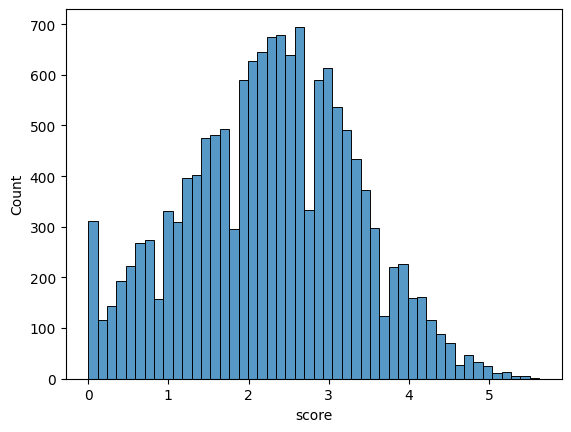

In [16]:
sns.histplot(data=df, x='score')

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='score'>

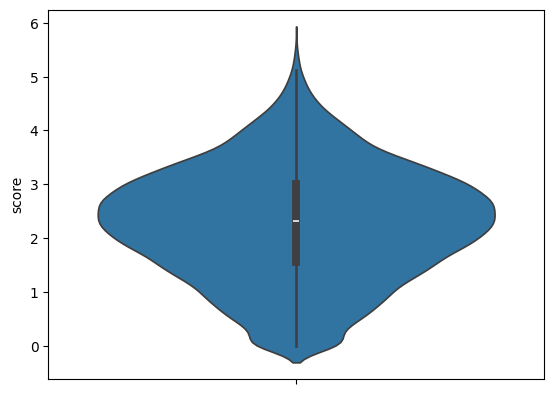

In [17]:
sns.violinplot(data=df, y='score')

<Axes: xlabel='degree', ylabel='score'>

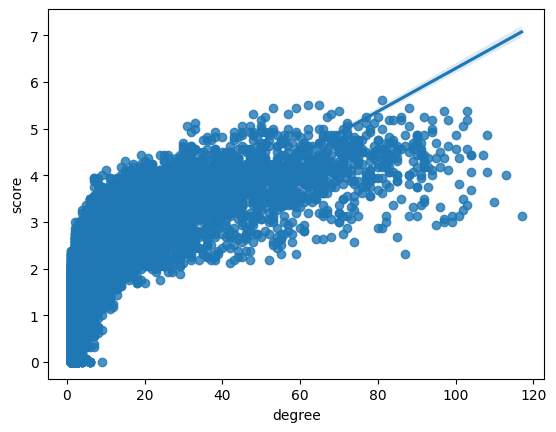

In [18]:
sns.regplot(data=df, x="degree", y="score")

### Analyze scores for new candidates from 13/02/2024

In [19]:
new_candidates = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
dict_new_candidates = dict([(gene, genes_df[genes_df['GENE'] == gene]['ENSG'].values[0]) for gene in new_candidates])

In [20]:
# check what percentage of new candidates is in interactome
len([nc for nc in dict_new_candidates.values() if nc in G.nodes()]) / len(dict_new_candidates.values())

0.68

In [21]:
# check scores of new candidates
df_new_candidates = df_res[df_res['ENSG'].isin(dict_new_candidates.values())]
df_new_candidates

,score,degree,candidates at d=1,candidates at d=2,candidates at d=3,candidates at d=4,GENE,ENSG
1795,3.5000,17,0,3,10,24,CCNA1,ENSG00000133101
3292,3.0625,11,0,3,7,23,CDC20B,ENSG00000164287
4765,2.7500,6,0,2,7,22,FAM221A,ENSG00000188732
5798,2.5625,3,0,0,10,21,SPATA6,ENSG00000132122
6883,2.3750,3,0,0,6,26,SPACA9,ENSG00000165698
7069,2.3125,7,0,1,3,27,SPATA24,ENSG00000170469
8483,2.0625,3,0,1,4,21,KIF27,ENSG00000165115
9027,1.9375,1,1,1,4,11,CCDC66,ENSG00000180376
9690,1.8125,1,0,1,2,21,FHAD1,ENSG00000142621
9812,1.8125,5,0,0,6,17,MYH7B,ENSG00000078814


/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


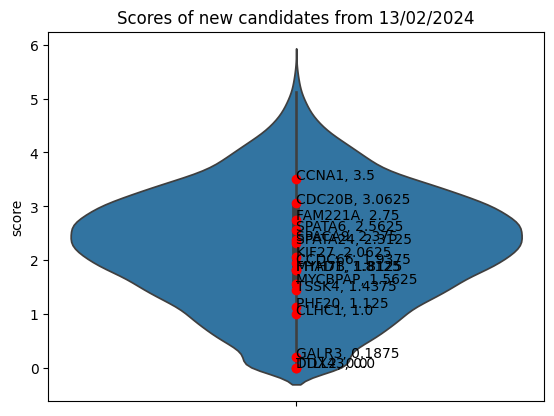

In [22]:
# plot scores of new candidates
sns.violinplot(data=df, y='score')
plt.title("Scores of new candidates from 13/02/2024")

for idx, row in df_new_candidates.iterrows():
    gene = row['GENE']
    score = row['score']
    plt.plot(score, 'or')
    plt.text(0, score, s=f"{gene}, {score}")

### Leave-one-out experiments

In [92]:
# remove a candidate from candidates list
left_out = candidates_MMAF[1]

left_out_idx = candidates_MMAF.index(left_out)

candidates_MMAF_new = candidates_MMAF[:left_out_idx] + candidates_MMAF[left_out_idx+1:]

print(f"Removed gene {left_out} from candidates")

# add the removed candidate to non-candidates list
nonCandidates_MMAF_new = [n for n in G.nodes() if n not in candidates_MMAF_new] 

Removed gene ENSG00000066185 from candidates


In [93]:
# calculate new centrality for every non-MMAF gene
dict_scores = {}

nodes_list = list(G.nodes())

for node in tqdm(nonCandidates_MMAF_new):
    node_idx = nodes_list.index(node)

    score = 0
    
    for candidate in candidates_MMAF_new:
        candidate_idx = nodes_list.index(candidate)

        try:
            # if there's no path connecting node to candidate then there's no contribution to node score
            d = nx.shortest_path_length(G, node, candidate)
            
            if d > 4:
                continue
            
            else:
                A = dict_adjacency.get(d)
                score += alpha ** d * A[node_idx, candidate_idx]
        
        except:
            continue

    dict_scores[node] = score
    
dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True))

  0%|          | 0/14426 [00:00<?, ?it/s]

100%|██████████| 14426/14426 [01:40<00:00, 144.18it/s]


In [94]:
# recalculate distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

for source_node in tqdm(nonCandidates_MMAF_new):
    dict_tmp = {}

    for target_node in candidates_MMAF_new:
        try:
            distance = nx.shortest_path_length(G, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between MMAF and non-MMAF gene: {longest_distance}")

  0%|          | 0/14426 [00:00<?, ?it/s]

100%|██████████| 14426/14426 [00:23<00:00, 603.21it/s]

Longest distance between MMAF and non-MMAF gene: 10


In [95]:
# get more info about each node (degree, candidates at distances)
dict_scores_full = {}

for n, score in dict_scores_sorted.items():
    dict_scores_full[n] = [score, 
                             G.degree(n), 
                             candidates_at_distance(dict_distances, n, 1), 
                             candidates_at_distance(dict_distances, n, 2),
                             candidates_at_distance(dict_distances, n, 3),
                             candidates_at_distance(dict_distances, n, 4)]

df_new = pd.DataFrame.from_dict(dict_scores_full, 
                            orient='index', 
                            columns=['score', 'degree', 'candidates at d=1', 'candidates at d=2', 'candidates at d=3', 'candidates at d=4'])

In [96]:
# get gene names to ENSG
genes_df = pd.read_csv("./data/canonicalGenes.tsv", sep='\t')

df_res_new = df_new.merge(genes_df, left_index=True, right_on='ENSG')
df_res_new.sort_values(by='score', inplace=True, ascending=False)
df_res_new.reset_index(inplace=True, drop=True)

In [97]:
# find results for the left-out gene
df_res_new[df_res_new['ENSG'] == left_out]

,score,degree,candidates at d=1,candidates at d=2,candidates at d=3,candidates at d=4,GENE,ENSG
303,4.1875,62,1,3,15,17,ZMYND12,ENSG00000066185


In [98]:
# get top 20 genes
df_top_new = df_res_new.head(20)
df_top_new

,score,degree,candidates at d=1,candidates at d=2,candidates at d=3,candidates at d=4,GENE,ENSG
0,5.5000,81,3,4,18,12,TXLNA,ENSG00000084652
1,5.2500,65,1,7,18,12,PDE4DIP,ENSG00000178104
2,5.2500,62,2,4,20,12,KRT18,ENSG00000111057
3,5.1875,88,2,3,22,11,RINT1,ENSG00000135249
4,5.1875,59,2,5,16,15,CDR2,ENSG00000140743
5,5.1250,103,2,5,15,16,NINL,ENSG00000101004
6,5.1250,70,1,8,13,16,KRT19,ENSG00000171345
7,5.1250,97,1,6,19,12,PLEC,ENSG00000178209
8,5.1250,67,1,6,19,12,TULP3,ENSG00000078246
9,5.1250,51,1,6,19,12,PRPF18,ENSG00000165630


/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 4.1875, 'ENSG00000066185, 4.1875')

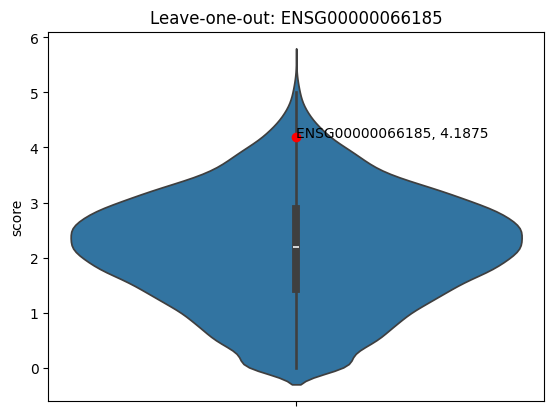

In [99]:
# plot score of the left-out gene
sns.violinplot(data=df_new, y='score')
plt.title(f"Leave-one-out: {left_out}")

score = df_res_new[df_res_new['ENSG'] == left_out]['score'].values[0]
plt.plot(score, 'or')
plt.text(0, score, s=f"{left_out}, {score}")

### Leave-one-out all candidates

In [125]:
def calculate_newCentrality(candidate):
    # remove one candidate from candidate list
    candidate_idx = candidates_MMAF.index(candidate)
    left_out = candidates_MMAF[candidate_idx]

    candidates_MMAF_new = candidates_MMAF[:candidate_idx] + candidates_MMAF[candidate_idx+1:]

    print(f"Removed gene {left_out} from candidates\n")

    # add the removed candidate to non-candidates list
    nonCandidates_MMAF_new = [n for n in G.nodes() if n not in candidates_MMAF_new]

    # calculate new centrality for every non-MMAF gene
    dict_scores = {}

    nodes_list = list(G.nodes())

    for node in tqdm(nonCandidates_MMAF_new):
        node_idx = nodes_list.index(node)

        score = 0
        
        for candidate in candidates_MMAF_new:
            candidate_idx = nodes_list.index(candidate)

            try:
                # if there's no path connecting node to candidate then there's no contribution to node score
                d = nx.shortest_path_length(G, node, candidate)
                
                if d > 4:
                    continue
                
                else:
                    A = dict_adjacency.get(d)
                    score += alpha ** d * A[node_idx, candidate_idx]
            
            except:
                continue

        dict_scores[node] = score
        
    dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True)) 

    df_new = pd.DataFrame.from_dict(dict_scores_sorted, 
                                orient='index', 
                                columns=['score'])
    
    return df_new, left_out

Removed gene ENSG00000118690 from candidates
Removed gene ENSG00000188738 from candidates
Removed gene ENSG00000158163 from candidates
Removed gene ENSG00000120051 from candidates
Removed gene ENSG00000111254 from candidates
Removed gene ENSG00000174799 from candidates
Removed gene ENSG00000147081 from candidates
Removed gene ENSG00000197653 from candidates










 98%|█████████▊| 14151/14426 [04:37<00:05, 46.21it/s]

Removed gene ENSG00000066185 from candidates


 99%|█████████▉| 14275/14426 [04:37<00:03, 47.83it/s]

 98%|█████████▊| 14181/14426 [04:40<00:04, 52.07it/s]

Removed gene ENSG00000135205 from candidates


  1%|          | 162/14426 [00:03<04:41, 50.74it/s]

  1%|▏         | 195/14426 [00:03<04:57, 47.81it/s]s]

Removed gene ENSG00000167646 from candidates



  1%|          | 99/14426 [00:01<04:21, 54.83it/s]]s]

Removed gene ENSG00000130413 from candidates



  1%|          | 103/14426 [00:01<04:00, 59.45it/s]s]

Removed gene ENSG00000142609 from candidates



  2%|▏         | 241/14426 [00:04<04:42, 50.24it/s]s]

Removed gene ENSG00000157796 from candidates


 99%|█████████▉| 14317/14426 [04:45<00:02, 41.75it/s]

  3%|▎         | 427/14426 [00:08<04:14, 55.09it/s]s]

Removed gene ENSG00000129646 from candidates



  1%|          | 104/14426 [00:02<05:13, 45.68it/s]

Removed gene ENSG00000077327 from candidates



 95%|█████████▌| 13746/14426 [04:50<00:13, 49.12it/s]

Removed gene ENSG00000181378 from candidates



 97%|█████████▋| 14062/14426 [04:56<00:07, 45.82it/s]

Removed gene ENSG00000119661 from candidates



  1%|          | 127/14426 [00:02<04:47, 49.80it/s]s]

Removed gene ENSG00000096872 from candidates



  1%|          | 145/14426 [00:02<04:41, 50.79it/s]s]

Removed gene ENSG00000109881 from candidates



 98%|█████████▊| 14198/14426 [04:59<00:04, 48.43it/s]

Removed gene ENSG00000179532 from candidates



  4%|▍         | 565/14426 [00:10<04:24, 52.45it/s]

Removed gene ENSG00000187775 from candidates



  1%|          | 150/14426 [00:02<05:12, 45.73it/s]s]

Removed gene ENSG00000141013 from candidates



  1%|          | 139/14426 [00:02<04:26, 53.70it/s]

Removed gene ENSG00000272514 from candidates



 98%|█████████▊| 14089/14426 [04:56<00:07, 46.32it/s]

Removed gene ENSG00000139537 from candidates


 95%|█████████▍| 13642/14426 [04:50<00:18, 43.53it/s]

 96%|█████████▌| 13806/14426 [04:52<00:15, 40.74it/s]

Removed gene ENSG00000165164 from candidates


 99%|█████████▉| 14248/14426 [05:00<00:04, 37.88it/s]

 99%|█████████▉| 14321/14426 [05:01<00:02, 40.36it/s]

Removed gene ENSG00000158486 from candidates



  2%|▏         | 329/14426 [00:07<05:03, 46.45it/s]s]

Removed gene ENSG00000185658 from candidates



  2%|▏         | 339/14426 [00:07<05:38, 41.62it/s]

Removed gene ENSG00000124721 from candidates



 98%|█████████▊| 14151/14426 [05:01<00:05, 50.75it/s]

Removed gene ENSG00000137473 from candidates


  2%|▏         | 286/14426 [00:05<04:00, 58.86it/s]

  2%|▏         | 270/14426 [00:05<04:14, 55.71it/s]s]

Removed gene ENSG00000152582 from candidates



  4%|▍         | 591/14426 [00:11<04:11, 54.98it/s]

Removed gene ENSG00000168026 from candidates



 98%|█████████▊| 14205/14426 [04:50<00:04, 49.47it/s]

Removed gene ENSG00000140623 from candidates



 96%|█████████▌| 13868/14426 [04:40<00:11, 48.64it/s]

Removed gene ENSG00000105792 from candidates



 95%|█████████▍| 13676/14426 [04:44<00:14, 50.75it/s]

Removed gene ENSG00000159625 from candidates



 96%|█████████▌| 13840/14426 [04:47<00:12, 47.58it/s]

Removed gene ENSG00000115423 from candidates



100%|██████████| 14426/14426 [02:33<00:00, 93.73it/s]]


Removed gene ENSG00000183833 from candidates



100%|██████████| 14426/14426 [02:36<00:00, 92.15it/s] 


Removed gene ENSG00000206530 from candidates



  0%|          | 10/14426 [00:00<02:33, 93.69it/s]

Removed gene ENSG00000161973 from candidates



  2%|▏         | 241/14426 [00:02<02:15, 104.38it/s]

Removed gene ENSG00000174844 from candidates



100%|██████████| 14426/14426 [02:42<00:00, 89.04it/s] 
/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when le

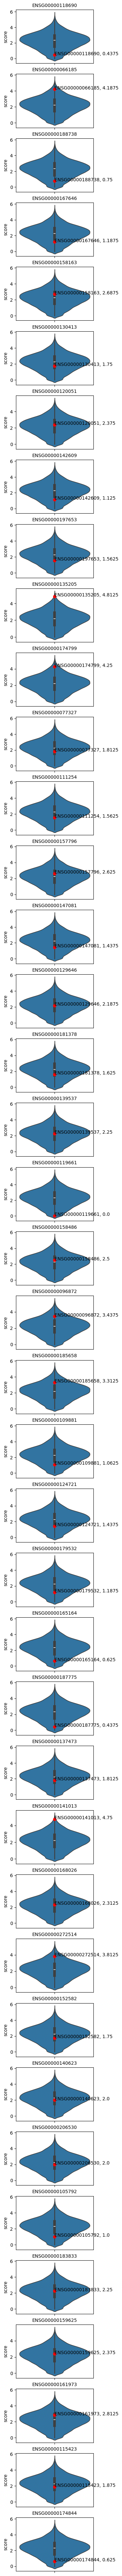

CPU times: user 1min 20s, sys: 36.9 s, total: 1min 57s
Wall time: 25min 1s


In [128]:
%%time

fig, ax = plt.subplots(len(candidates_MMAF), 1, figsize=(3, 100))

# create a dictionary to save scores for left-out candidates
dict_candidates = {}

# for plotting
i = 0

pool_obj = multiprocessing.Pool()

res_dataframes = pool_obj.map(calculate_newCentrality, candidates_MMAF)

pool_obj.close()

for results in res_dataframes:
    df_new = results[0]
    left_out = results[1]
    # plot score of the left-out gene
    sns.violinplot(data=df_new, y='score', ax=ax[i])

    score = df_new.loc[left_out]['score']
    ax[i].plot(score, 'or')
    ax[i].text(0, score, s=f"{left_out}, {score}")
    ax[i].legend().remove()
    ax[i].set_title(left_out, fontsize=10)

    dict_candidates[left_out] = score

    # for keeping track of plotting
    i += 1

plt.show()